#### Facial recognition using SVD ####

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import TruncatedSVD  # Sklearn has its own svd operator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from skimage import transform
from PIL import Image
import io
import requests

In [2]:
# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape

# The dataset is already in a flattened format
X = lfw_people.data
n_features = X.shape[1]

# The target labels (person's names)
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(f"Dataset size: {n_samples} samples")
print(f"Each image has {n_features} features (pixels)")

Dataset size: 1288 samples
Each image has 1850 features (pixels)


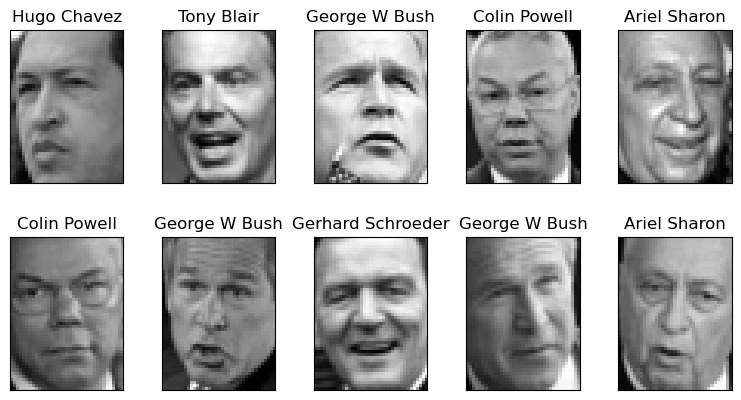

In [3]:
# Visualize some example faces from the dataset
def show_faces(images, titles, h, w, n_row=2, n_col=5):
    """Helper function to plot example faces"""
    plt.figure(figsize=(1.5 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Show the first 10 faces from the dataset
example_faces = lfw_people.images[:10]
example_titles = [target_names[y[i]] for i in range(10)]
show_faces(example_faces, example_titles, h, w)

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform SVD to reduce dimensionality
# Keep only the top 500 components (this can be adjusted)
svd = TruncatedSVD(n_components=900)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

print(f"Reduced training data to {X_train_svd.shape[1]} components using SVD.")

Reduced training data to 900 components using SVD.


In [5]:
# Step 4: Train a classifier using the reduced features
clf = SVC(C=100)
clf.fit(X_train_svd, y_train)

# Step 5: Predict on the test set
y_pred = clf.predict(X_test_svd)

In [6]:
# Step 6: Print classification results
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=target_names))

# Step 7: Visualize the "eigenfaces" (principal components)
eigenfaces = svd.components_.reshape((900, h, w))

Accuracy: 0.8165374677002584
                   precision    recall  f1-score   support

     Ariel Sharon       0.61      0.78      0.68        18
     Colin Powell       0.76      0.84      0.80        69
  Donald Rumsfeld       0.68      0.62      0.65        34
    George W Bush       0.90      0.90      0.90       166
Gerhard Schroeder       0.78      0.81      0.79        31
      Hugo Chavez       0.92      0.58      0.71        19
       Tony Blair       0.81      0.76      0.78        50

         accuracy                           0.82       387
        macro avg       0.78      0.75      0.76       387
     weighted avg       0.82      0.82      0.82       387



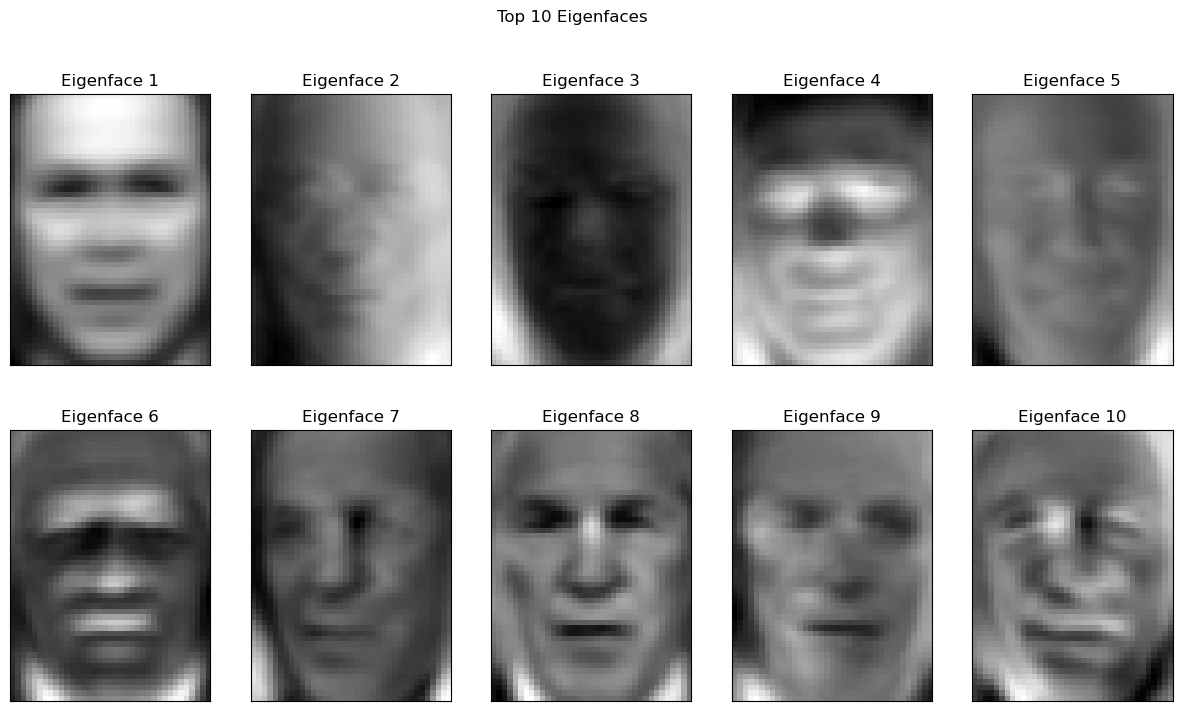

In [7]:
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"Eigenface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Top 10 Eigenfaces")
plt.show()

- Eigenfaces: These are the principal components extracted by SVD. Each eigenface represents a pattern or feature that contributes significantly to the variance in the dataset. The top eigenfaces capture large-scale facial features like the shape of the head, eyes, and nose.
- By using SVD, we reduce the dimensionality of the image data from several thousand pixels (original features) to a smaller number (100 components in this example). This reduction allows the classifier to focus on the most important features of the face, improving efficiency and reducing overfitting.
- The classification model uses the reduced feature set to perform facial recognition. Despite the dimensionality reduction, the classifier can still achieve high accuracy because the most important features are retained through SVD.

Predicted person: George W Bush


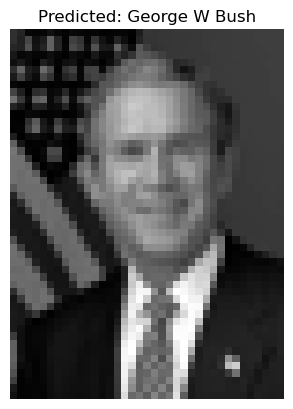

In [8]:
# Function to preprocess the local image
def preprocess_local_image(image_path):
    
    # Open the image from the local path
    img = Image.open(image_path)

    # Convert to grayscale and resize to 40x40 (same as LFW images)
    img = img.convert("L")
    img_resized = img.resize((w, h))  # 40x40 dimensions from LFW

    # Convert to numpy array and flatten it to match the LFW format
    img_array = np.asarray(img_resized, dtype=np.float32).flatten()

    # Return the preprocessed image
    return img_array

# Predict using an image stored locally
image_path =  'George_Bush.jpeg'  # Replace with your local image path
local_image = preprocess_local_image(image_path)

# Project the new image into the reduced feature space using SVD
local_image_svd = svd.transform([local_image])

# Predict the label
predicted_label = clf.predict(local_image_svd)
print(f"Predicted person: {target_names[predicted_label[0]]}")

# Visualize the input image from the local file
plt.imshow(local_image.reshape((h, w)), cmap='gray')
plt.title(f"Predicted: {target_names[predicted_label[0]]}")
plt.axis('off')
plt.show()
